In [2]:
from numba import jit, prange

In [3]:
import cupy as cp

In [15]:
import cudf as cf

In [5]:
import numpy as np
from scipy import linalg
from statsmodels.nonparametric.smoothers_lowess import lowess
import math
import seaborn as sns

In [6]:
import pandas as pd
from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.seasonal import DecomposeResult
# from statsmodels.tsa.filters._utils import _maybe_get_pandas_wrapper_freq
import statsmodels.api as sm

In [7]:
from time import perf_counter

In [8]:
from math import ceil

In [9]:
def lowess2(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest


In [10]:
def lowess_inline(x, y, f=2. / 3., it=3, dl=1):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    # w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    # w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.repeat(dl, n)
    for iteration in range(it):
        for i in range(n):
            row = i
            weights = delta * np.power(1 - np.power(np.clip(np.abs((x[row, None] - x[None, :])/h[row]), 0.0, 1.0), 3.0), 3.0)
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest


In [48]:
@jit(parallel=True, nopython=False)
def lowess_cp_inline(x, y, f=2. / 3., it=3, dl = 1.0):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = cp.int(cp.ceil(f * n))
    h = cp.zeros(n)
    for i in prange(n):
        h[i] = cp.sort(cp.abs(x - x[i]))[r]
    yest = cp.zeros(n)
    delta = cp.repeat(cp.array(dl), n)
    for iteration in prange(it):
        for i in range(n):
            row = i
            weights = delta * cp.power(1 - cp.power(cp.clip(cp.abs((x[row, None] - x[None, :])/h[row]), 0.0, 1.0), 3.0), 3.0)
            b = cp.array(cp.array([cp.sum(weights * y), cp.sum(weights * y * x)]))
            A = cp.array(cp.array([cp.array([cp.sum(weights), cp.sum(weights * x)]), cp.array([cp.sum(weights * x), cp.sum(weights * x * x)])]))
            beta = cp.linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = cp.float32(cf.Series(cp.abs(residuals)).median())
        delta = cp.clip(residuals / (6.0 * s), -1, 1)
        delta = cp.power((1 - cp.power(delta, 2.0)), 2)
    return yest

In [12]:
n_diff = 1
df = pd.read_csv('data/ppnet_metar_v7.csv',  sep=';', index_col=0)
X, y = df.drop('Consumption', axis=1), df.Consumption
y_diff = y.diff(n_diff).dropna()
y_diff_index = y_diff.index

In [109]:
y = y_diff.values[:20000]
x = np.array([i for i in range(len(y))])
f = 0.6

In [110]:
s = perf_counter()
low_res = lowess_inline(x, y, f, dl=0.01, it=1)
cp.cuda.Stream.null.synchronize()
e = perf_counter()
print(e - s)

51.26436364650726


In [111]:
low_res[:20]

array([-21.855728  , -21.85274397, -21.84975843, -21.84677136,
       -21.84378278, -21.84079267, -21.83780105, -21.83480791,
       -21.83181325, -21.82881708, -21.82581938, -21.82282017,
       -21.81981945, -21.8168172 , -21.81381344, -21.81080817,
       -21.80780138, -21.80479307, -21.80178325, -21.79877192])

# CuPy

In [46]:
y = cp.array(y_diff.values[:1000])
x = cp.array([i for i in range(len(y))])
f = 0.6

In [50]:
s = perf_counter()
low_res = lowess_cp_inline(x, y, f, dl=0.01, it=1)
cp.cuda.Stream.null.synchronize()
e = perf_counter()
print(e - s)

2.3148109763860703


In [23]:
low_res[:20]

array([218.61519745, 218.76379599, 218.91395876, 219.06567426,
       219.21892757, 219.37368972, 219.52990176, 219.68747937,
       219.84633821, 220.00639643, 220.16757282, 220.32979231,
       220.49298454, 220.65708583, 220.82203077, 220.98774884,
       221.15415894, 221.32117184, 221.4886986 , 221.65665012])

In [12]:
n = x.shape[0]
r = cp.int(cp.ceil(f * n))
h = cp.array([cp.sort(cp.abs(x - x[i]))[r] for i in range(n)])

In [26]:
i = 1

In [27]:
r

12000

array([    1,     0,     1, ..., 19996, 19997, 19998])

In [29]:
cp.sort(cp.abs(x - x[i]))[r]

array(11999)

In [31]:
len(h)

20000

In [39]:
s = perf_counter()
h = cp.zeros(n)
for i in range(n):
    h[i] = cp.sort(cp.abs(x - x[i]))[r]
cp.cuda.Stream.null.synchronize()
e = perf_counter()
print(e - s)

6.742009915411472


In [89]:
dl = 1.0


In [90]:
row = 0
i = 0
weights = delta * cp.power(1 - cp.power(cp.clip(cp.abs((x[row, None] - x[None, :])/h[row]), 0.0, 1.0), 3.0), 3.0)

In [91]:
b = cp.array(cp.array([cp.sum(weights * y), cp.sum(weights * y * x)]))

In [92]:
b

array([   82397.93509349, 16225916.87145182])

In [93]:
A = cp.array(cp.array([cp.array([cp.sum(weights), cp.sum(weights * x)]), cp.array([cp.sum(weights * x), cp.sum(weights * x * x)])]))

In [94]:
beta = cp.linalg.solve(A, b)
beta

array([2.18615197e+02, 9.65394295e-02])

In [95]:
yest[i] = beta[0] + beta[1] * x[i]

In [96]:
residuals = y - yest

In [97]:
s = cp.float32(cdf.Series(cp.abs(residuals)).median())

In [98]:
delta = cp.clip(residuals / (6.0 * s), -1, 1)

In [99]:
delta = cp.power((1 - cp.power(delta, 2.0)), 2)

In [262]:
n = len(x)
r = int(np.ceil(f * n))
h = np.array([np.sort(np.abs(x - x[i]))[r] for i in range(n)])

In [263]:
n, r

(100, 25)

In [264]:
h.shape

(100,)

In [353]:
row = 1
w_row = np.power(1 - np.power(np.clip(np.abs((x[row, None] - x[None, :])/h[row]), 0.0, 1.0), 3.0), 3.0)
weights = delta * w_row

In [355]:
b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
b

array([ 44541.39811984, 122137.6105881 ])

In [356]:
A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
A

array([[  15.3855117 ,  120.33914737],
       [ 120.33914737, 1378.30185681]])

In [358]:
beta = linalg.solve(A, b)
beta

array([6943.93126218, -517.65812646])

In [360]:
yest[row] = beta[0] + beta[1] * x[row]
yest[row]

6426.273135715355

In [344]:
w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)

In [345]:
w[:, 1]

array([0.04166667, 0.        , 0.04166667, 0.08333333, 0.125     ,
       0.16666667, 0.20833333, 0.25      , 0.29166667, 0.33333333,
       0.375     , 0.41666667, 0.45833333, 0.5       , 0.54166667,
       0.58333333, 0.625     , 0.66666667, 0.70833333, 0.75      ,
       0.79166667, 0.83333333, 0.875     , 0.91666667, 0.95833333,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [346]:
w = (1 - w ** 3) ** 3

In [347]:
w[:, 1]

array([0.999783  , 1.        , 0.999783  , 0.99826489, 0.99415206,
       0.98617531, 0.97311781, 0.95385361, 0.92739586, 0.89295331,
       0.84999297, 0.79830593, 0.73807253, 0.66992188, 0.59497928,
       0.51489433, 0.43184014, 0.3484733 , 0.26784168, 0.19322586,
       0.12789754, 0.07477612, 0.03596253, 0.01212663, 0.00172213,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [281]:
yest = np.zeros(n)
delta = np.ones(n)

In [259]:
np.power((1 - np.power(np.clip(np.abs((x[0, None] - x[None, :])/h), 0.0, 1.0), 3.0)), 3.0)

array([[1.        , 0.999783  , 0.99802875, 0.99241221, 0.97941084,
        0.95385361, 0.90846949, 0.8337333 , 0.71880951, 0.5554558 ,
        0.3484733 , 0.13654449, 0.00972811, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [252]:
w[:, 0]

array([1.        , 0.99980801, 0.99846479, 0.99482495, 0.98776226,
       0.97619149, 0.95909867, 0.93557909, 0.90488204, 0.86646079,
       0.82002586, 0.76559882, 0.70356317, 0.63470792, 0.56025877,
       0.4818903 , 0.40171203, 0.32221935, 0.24619951, 0.17658114,
       0.11621427, 0.06756635, 0.03231788, 0.01083964, 0.00153137,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [253]:
weights = delta * w[:, 0]
weights

array([1.        , 0.99980801, 0.99846479, 0.99482495, 0.98776226,
       0.97619149, 0.95909867, 0.93557909, 0.90488204, 0.86646079,
       0.82002586, 0.76559882, 0.70356317, 0.63470792, 0.56025877,
       0.4818903 , 0.40171203, 0.32221935, 0.24619951, 0.17658114,
       0.11621427, 0.06756635, 0.03231788, 0.01083964, 0.00153137,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [204]:
b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
b

array([ 44466.19498899, 125379.10012283])

In [205]:
A = np.array([[np.sum(weights), np.sum(weights * x)], [np.sum(weights * x), np.sum(weights * x * x)]])
A

array([[  14.96429847,  114.97384293],
       [ 114.97384293, 1302.0922588 ]])

In [206]:
A.shape

(2, 2)

In [157]:
x = np.arange(56000).astype(np.int16)

In [158]:
x.dtype

dtype('int16')

In [159]:
np.abs((x[:, None] - x[None, :]))

KeyboardInterrupt: 

In [125]:
y_diff.shape

(56927,)

In [70]:

# n = 100
# x = np.linspace(0, 2 * math.pi, n)
# y = np.sin(x) + 0.3 * np.random.randn(n)

# f = 0.25
# yest = lowess2(x, y, f=f, iter=3)
# yest2 = lowess(y, x, frac=f, it=3)

In [7]:
n_diff = 1
df = pd.read_csv('data/ppnet_metar_v7.csv',  sep=';', index_col=0)
X, y = df.drop('Consumption', axis=1), df.Consumption
y_diff = y.diff(n_diff).dropna()
y_diff_index = y_diff.index

In [8]:
y_diff

Datetime
2013-01-01 01:00:00     2940.0
2013-01-01 02:00:00     1864.0
2013-01-01 03:00:00     1048.0
2013-01-01 04:00:00     7740.0
2013-01-01 05:00:00    21576.0
                        ...   
2019-06-30 19:00:00     1302.0
2019-06-30 20:00:00    -1005.0
2019-06-30 21:00:00      918.0
2019-06-30 22:00:00    -2950.0
2019-06-30 23:00:00    -4319.0
Name: Consumption, Length: 56927, dtype: float64

In [9]:
y = y_diff.values
x = np.array([i for i in range(len(y))])
f = 0.25

In [77]:
# yest = lowess2(x, y, f=f, iter=3)

In [80]:
# yest2 = lowess(y, x, frac=f, it=3)

In [81]:
# yest2[:, 1]

array([ -767.81370977,  -767.80717149,  -767.80064322, ...,
       -1135.2570173 , -1135.30611808, -1135.35521101])

In [10]:
y = y_diff.values
x = np.array([i for i in range(len(y))])
f = 0.25
iter = 3

In [11]:
y = cp.array(y)
x = cp.array(x)

In [15]:
n = x.shape[0]
r = int(cp.ceil(f * n))

In [18]:
r

14232

In [13]:
cp.abs(x - x[0])

array([    0,     1,     2, ..., 56924, 56925, 56926])

In [17]:
n

56927

In [25]:
x[:, None]

array([[    0],
       [    1],
       [    2],
       ...,
       [56924],
       [56925],
       [56926]])

In [119]:
y.shape

(56927,)

In [115]:
y[None, :]

array([[ 2940.,  1864.,  1048., ...,   918., -2950., -4319.]])

In [117]:
y[:, None]

array([[ 2940.],
       [ 1864.],
       [ 1048.],
       ...,
       [  918.],
       [-2950.],
       [-4319.]])

In [118]:
y[None, :] - y[:, None]

MemoryError: std::bad_alloc: CUDA error at: ../include/rmm/mr/device/cuda_memory_resource.hpp66: cudaErrorMemoryAllocation out of memory

In [34]:
n = x.shape[0]
r = int(cp.ceil(f * n))
h = cp.zeros(n)
for i in range(n):
    abs_value = cp.abs(x - x[i])
    abs_value_sorted = cp.sort(abs_value)
    ret_value = abs_value_sorted[r]
    h[i] = ret_value
w = cp.ones(n)
yest = cp.zeros(n)
delta = cp.ones(n)

In [37]:
n = x.shape[0]
r = int(cp.ceil(f * n))
h = cp.zeros(n)
for i in range(n):
    h[i] = cp.sort(cp.abs(x - x[i]))[r]
w = cp.ones(n)
yest = cp.zeros(n)
delta = cp.ones(n)

In [86]:
from time import perf_counter

In [105]:
s = perf_counter()
md_var = cp.sort(residuals)[residuals.shape[0]/2]
cp.cuda.Stream.null.synchronize()
e = perf_counter()
print(e - s)

0.0015932098031044006


In [106]:
s = perf_counter()
md_var = cdf.Series(residuals).median()
cp.cuda.Stream.null.synchronize()
e = perf_counter()
print(e - s)

0.004645772278308868


In [107]:
for iteration in range(3):
    for i in range(n):
        weights = delta * w[i]
        b = cp.array([cp.sum(weights * y), cp.sum(weights * y * x)])
        A = cp.array([[cp.int(cp.sum(weights)), cp.int(cp.sum(weights * x))], [cp.int(cp.sum(weights * x)), cp.int(cp.sum(weights * x * x))]])
        beta = cp.linalg.solve(A, b)
        yest[i] = beta[0] + beta[1] * x[i]

    residuals = y - yest
    s = cdf.Series(cp.abs(residuals)).median()
    delta = cp.clip(residuals / (6.0 * s), -1, 1)
    delta = (1 - delta ** 2) ** 2

In [108]:
yest

array([-812.41375125, -812.41259224, -812.41143324, ..., -746.43843939,
       -746.43728038, -746.43612138])

In [109]:
import matplotlib.pyplot as plt

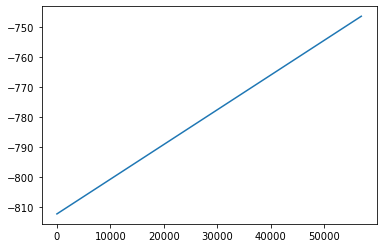

In [112]:
plt.plot(cp.asnumpy(yest))

In [ ]:
# array([ -767.81370977,  -767.80717149,  -767.80064322, ...,
#        -1135.2570173 , -1135.30611808, -1135.35521101])

In [ ]:
trend = yest
observed = 

In [ ]:
detrended = observed - trend

In [4]:
period=365
lo_frac=0.6
lo_delta=0.01

In [5]:
observed = np.asanyarray(df).squeeze()

NameError: name 'df' is not defined